
- densenet/resnet-inception/inceptionv4 apply
-  resnet/inceptions: with smaller parameters



In [1]:
import os
from glob import glob
import numpy as np
import nibabel as nib
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
import tqdm
from operator import add
import matplotlib.pyplot as plt
import easydict

In [2]:
import wandb

!wandb login

wandb: Currently logged in as: tonge (use `wandb login --relogin` to force relogin)


In [3]:
# os.getcwd()
!pwd

/home/chaeeun/Desktop/brain disease prediction


In [4]:
data = np.load('./sliced_datas/sliced_746.npy')
# 747: 메모리 에러

In [5]:
label_1 = np.load('./labels/label_1.npy')
type(label_1)

numpy.ndarray

In [6]:
X_train = data[:621]
X_test = data[621:]
# y_train = norm_label[:621]
# y_test = norm_label[621:]
y_train = label_1[:621]
y_test = label_1[621:]

In [7]:
datadict = {
    'X_train': X_train, 
    'y_train' : y_train,
    'X_test': X_test,
    'y_test': y_test
}

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
class mridataset(Dataset):
    def __init__(self, data, data_type):
        if data_type == 'train':
            self.X = data['X_train']
            self.y = data['y_train']
        elif data_type == 'test':
            self.X = data['X_test']
            self.y = data['y_test']
            
        assert len(self.X) == len(self.y), "length should be same between input and label"
        
        self.X = torch.FloatTensor(self.X)#cpu tensor
        self.y = torch.FloatTensor(self.y)#cpu tensor
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return {
            'X': X,
            'y_target': y
        }

# MODELS

In [10]:
# import torchvision.models as models
# r3d_18 = models.video.r3d_18(pretrained=True, )
# print(r3d_18)


# parameter change

In [12]:
# # r3d_18.parameters change
# r3d_18.fc = nn.Linear(in_features = 512, out_features = 1, bias = True)
# nn.sequential -->
#                          nn.Linear(in_features = 256, out_features = 64, bias = True),
#                          nn.Linear(in_features = 64, out_features = 1, bias = True))
#nn.Linear(in_features = 512, out_features = 1, bias = True)
# r3d_18.stem[0] = nn.Conv3d(1, 64, kernel_size = (3, 7, 7), stride = (1, 2, 2), padding = (1, 3, 3), bias = False)

In [12]:
#results
# r3d_18.parameters

In [22]:
# model = r3d_18
# model.to(device)

## pretrained model

In [11]:
from models.okankop_resnet import resnet50

model = resnet50(num_classes=1, sample_size=140, sample_duration=16)
# pretrained 불러오기
model.load_state_dict(torch.load('kinetics_resnet_50_RGB_16_best.pth', map_location=device), strict=False)
# 파라미터 잘 불러와졌는지 확인하는 코드
model.state_dict() ## 에러 안 나고 파라미터 값 나오면 잘 된 거

/home/chaeeun/Desktop/brain disease prediction/models/okankop_resnet.py:145: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')


OrderedDict([('conv1.weight',
              tensor([[[[[ 2.0445e-03,  1.2253e-02, -6.4177e-03,  ...,  1.3240e-02,
                          -7.6506e-03, -3.8612e-03],
                         [-6.0878e-03,  3.8697e-03, -1.1535e-03,  ...,  2.4889e-03,
                          -1.0456e-02, -1.5113e-02],
                         [ 4.9914e-03, -5.0980e-03, -2.2056e-04,  ...,  9.8770e-03,
                          -2.3298e-03, -2.4543e-03],
                         ...,
                         [ 1.0759e-03,  9.4797e-03, -8.8850e-03,  ..., -1.1381e-02,
                          -8.6690e-04, -1.9843e-02],
                         [ 8.9033e-04, -7.4042e-03,  1.1558e-02,  ...,  6.1405e-04,
                           7.7134e-03, -1.3244e-02],
                         [-9.3872e-03, -1.0690e-02,  7.7415e-03,  ..., -1.3886e-02,
                           6.3147e-03, -2.6339e-03]],
              
                        [[ 1.7928e-03,  6.4924e-03,  1.1245e-02,  ..., -1.3849e-02,
                  

In [12]:
model.conv1 = nn.Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
model.fc = nn.Linear(in_features = 45056, out_features = 1, bias = True)
model.to(device)

ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv3d(64

## densenet

In [10]:
#densenet
#from model.densenet import densenet
#model = densenet(121)
#model.to(device)

## resnet

In [11]:
# #resnet
# from model.resnet import *
# model =  generate_model(50, n_classes=1)
# model.to(device)

## inception_resnet_v2

In [9]:
# from model.inception_resnet_v2_edit import Inception_ResNetv2
# model = Inception_ResNetv2(classes = 1)
# model.to(device)

## inceptionv4

In [19]:
# from model.inceptionv4 import Inceptionv4
# model = Inceptionv4(classes=1)
# model.to(device)


# config dictionary

In [13]:
config = easydict.EasyDict({'n_epoch': 70,
                           'batch_size':8,
                           'lr': 0.001,
                           'save_dir':'./',
                           'dropout' : 0.2, 
                            'modelname' : 'resnet50_pretrained',
                            'dataname' : 'sliced_746'
                           })

In [14]:
train_loader = DataLoader(mridataset(datadict, data_type = 'train'), batch_size = config.batch_size, num_workers = 8, shuffle = True)
#num_workers: cpu 여러개로 학습을 시켜라(8)
test_loader = DataLoader(mridataset(datadict, data_type = 'test'), batch_size = config.batch_size, num_workers = 8, shuffle = False)

In [15]:
# #save&load path
# filename = f'Model_{config.modelname}_batch_{config.batch_size}_lr_{config.lr}'
# output_path = os.path.join(config.save_dir, filename)
# print('Model will be saved in {}'.format(output_path))

RMSProp with decay of 0.9 and epsilon(e//what is this??)= 1.0.  We used a learning rate of 0.045, decayed every two epochs using an exponential rate of 0.94.  --> decay every 2 epochs??using an exponential rate of 0.94===>lr.scheduler??

In [16]:
#Loss
criterion = nn.MSELoss()
criterion2 = nn.L1Loss()
#optimizer#
optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)#this was for resnet
#optimizer = torch.optim.RMSprop(model.parameters(), lr = config.lr)#, weight_decay = 0.9, momentum = 0.9)#for inception resnet

In [17]:
#trainer
wandb.init(project=config.modelname +'_'+ config.dataname + '_' + str(config.n_epoch), config = config)
wandb.watch(model, log='all')

start = torch.cuda.Event(enable_timing = True)
end = torch.cuda.Event(enable_timing = True)

start.record()
loss_plot, val_loss_plot = [], []
maeloss_plot, maeval_loss_plot = [], []
y_each_maeloss_plot = []
for n_epoch in range(1, config.n_epoch + 1):
    print(f'Train Epoch {n_epoch} start!')
    avg_train_loss = 0
    avg_train_mae = 0
    
    model.train()
    
    for iter, batch in enumerate(train_loader):
        X = batch['X'].to(device)
        y_target = batch['y_target'].to(device)
        optimizer.zero_grad()#optimizer reset
        
        y_pred = model(X)
        loss = criterion(y_pred, y_target)
        loss2 = criterion2(y_pred, y_target)


        loss.backward()
        optimizer.step()
        avg_train_loss += loss.item() / len(train_loader)
        avg_train_mae += loss2.item() / len(train_loader)

        
        
    print('[Train] loss: {:.3f}'.format(avg_train_loss))
    print('[Train] mae_loss: {:.3f}'.format(avg_train_mae))
    loss_plot.append(avg_train_loss)
    maeloss_plot.append(avg_train_mae)

    # wandb.log({'Train mse Loss' : avg_train_loss, 'Train mae Loss': avg_train_mae})#0, 2, 4, ...
    

        #evaluation
    model.eval()
    avg_test_loss = 0
    avg_test_mae = 0
        
    with torch.no_grad(): #no need to compute gradient
#         y_each_maeloss = [0, 0, 0, 0, 0]
        y_predicted = []
        for iter, batch in enumerate(test_loader):
            X = batch['X'].to(device)
            y_target = batch['y_target'].to(device)

            y_pred = model(X)

    
            if n_epoch == config.n_epoch:
                y_predicted.append(y_pred)


            loss = criterion(y_pred, y_target)
            loss2 = criterion2(y_pred, y_target)

            avg_test_loss += loss.item()/len(test_loader)
            avg_test_mae += loss2.item()/len(test_loader)

        print('[Test]  loss: {:.3f}'.format(avg_test_loss))
        print('[Test]  mae_loss: {:.3f}'.format(avg_test_mae))
#         print('[Test, y_each_maeloss]: ',y_each_maeloss)
        print('\n')
        val_loss_plot.append(avg_test_loss)
        maeval_loss_plot.append(avg_test_mae)
#         y_each_maeloss_plot.append(y_each_maeloss)
        wandb.log({'Train mse Loss' : avg_train_loss, 'Train mae Loss': avg_train_mae, 'Test mse Loss': avg_test_loss, 'Test mae Loss': avg_test_mae})
    
    
end.record()
torch.cuda.synchronize()
print(start.elapsed_time(end), "ms")

# wandb.finish()
y_predicted_concat = torch.cat([*y_predicted], dim = 0)

y1_p = y_predicted_concat.reshape(100,1).cpu()
# y2_p = y_predicted_concat[:, 1].reshape(100,1).cpu()

#정답치
y1 = label_1[621:].reshape(100,1)
# y2 = unnorm_label[621:, 1].reshape(100,1)


one = np.hstack((y1_p, y1))
# two = np.hstack((y2_p, y2))


scat_1 = [[x, y] for (x, y) in one]#zip(one[:,0], one[:,1])
# scat_2 = [[x, y] for (x, y) in two]#zip(one[:,0], one[:,1])


table_1 = wandb.Table(data = scat_1, columns = ['predicted', 'truth'])
scatter_1 = wandb.plot.scatter(table_1, x = 'predicted', y = 'target', title = 'scat_1')

# table_2 = wandb.Table(data = scat_2, columns = ['predicted', 'truth'])
# scatter_2 = wandb.plot.scatter(table_2, x = 'predicted', y = 'target', title = 'scat_2')


wandb.log({ 'scatter_1': scatter_1})

wandb.finish()



Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tonge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Train Epoch 1 start!
[Train] loss: 54.511
[Train] mae_loss: 2.389
[Test]  loss: 0.185
[Test]  mae_loss: 0.227


Train Epoch 2 start!
[Train] loss: 0.170
[Train] mae_loss: 0.268
[Test]  loss: 0.116
[Test]  mae_loss: 0.183


Train Epoch 3 start!
[Train] loss: 0.089
[Train] mae_loss: 0.200
[Test]  loss: 0.089
[Test]  mae_loss: 0.228


Train Epoch 4 start!
[Train] loss: 0.065
[Train] mae_loss: 0.168
[Test]  loss: 0.019
[Test]  mae_loss: 0.110


Train Epoch 5 start!
[Train] loss: 0.040
[Train] mae_loss: 0.121
[Test]  loss: 0.009
[Test]  mae_loss: 0.063


Train Epoch 6 start!
[Train] loss: 0.043
[Train] mae_loss: 0.132
[Test]  loss: 0.009
[Test]  mae_loss: 0.075


Train Epoch 7 start!
[Train] loss: 0.044
[Train] mae_loss: 0.131
[Test]  loss: 0.005
[Test]  mae_loss: 0.045


Train Epoch 8 start!
[Train] loss: 0.046
[Train] mae_loss: 0.132
[Test]  loss: 0.036
[Test]  mae_loss: 0.170


Train Epoch 9 start!
[Train] loss: 0.049
[Train] mae_loss: 0.148
[Test]  loss: 0.011
[Test]  mae_loss: 0.091




Train mse Loss,0.03665
Train mae Loss,0.10687
Test mse Loss,0.00417
Test mae Loss,0.04636
_runtime,9723
_timestamp,1636546875
_step,70


Train mse Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train mae Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
Test mse Loss,▆▄▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁█▁
Test mae Loss,▅▄▂▂▃▂▃▂▃▁▂▃▂▂▁▁▃▂▂▂▂▃▂▃▂▂▁▂▄▂▂▂▂▃▁▂▁▂█▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
# y_predicted_concat = torch.cat([*y_predicted], dim = 0)


In [25]:
# run = wandb.init(project = config.modelname +'_'+ config.dataname + '_' + str(config.n_epoch), config = config)

artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model.pth')

wandb.log_artifact(artifact)
wandb.join()

Train mse Loss,0.79483
Train mae Loss,0.66267
Test mse Loss,3.75818
Test mae Loss,1.3394
_runtime,165
_timestamp,1634111681
_step,9


Train mse Loss,█▆▄▂▄▂▂▁▃▁
Train mae Loss,█▇▄▂▃▃▄▁▂▃
Test mse Loss,█▁▁▁▁▁▁▁▁▁
Test mae Loss,█▁▁▁▁▁▁▁▁▁
_runtime,▁▂▃▃▄▅▆▆▇█
_timestamp,▁▂▃▃▄▅▆▆▇█
_step,▁▂▃▃▄▅▆▆▇█


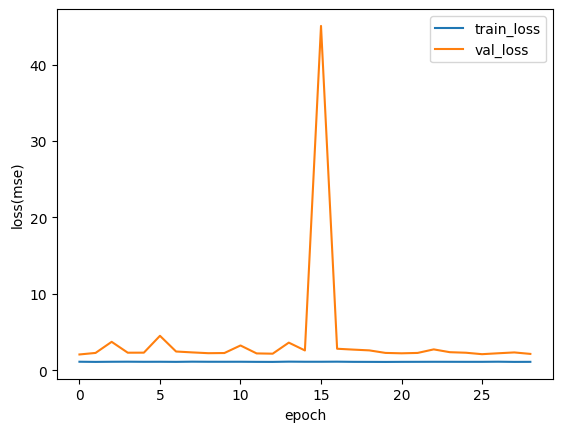

In [35]:
#mse
plt.plot(loss_plot[1:], label='train_loss')
plt.plot(val_loss_plot[1:], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mse)')
plt.legend()
plt.show()

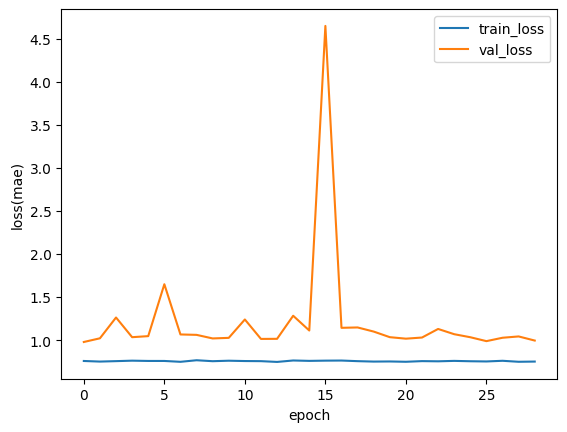

In [36]:
#mae
plt.plot(maeloss_plot[1:], label='train_loss')
plt.plot(maeval_loss_plot[1:], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss(mae)')
plt.legend()
plt.show()

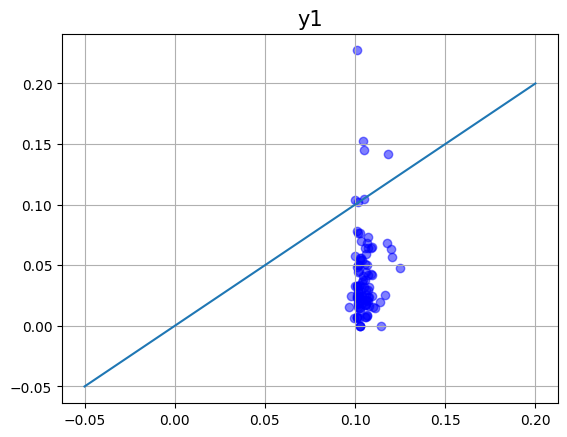

In [19]:

x = np.arange(-0.05, 0.25, 0.05)
plt.plot(x,x)
plt.title("y1", fontsize = 15)
plt.scatter( one[:,0], one[:, 1], color = 'blue', alpha = .5)
# plt.scatter(n_1[:,0], n_1[:,1], color = 'red', alpha = .5)
plt.grid()
plt.show()

# x = np.arange(30, 38, 1)
# plt.plot(x, x)
# plt.title("y2", fontsize = 15)
# plt.scatter( two[:,0], two[:, 1], color = 'blue', alpha = .5)
# plt.grid()
# plt.show()
